## Data Collection

### pdf to txt by scenes

In [4]:
import fitz # PyMuPDF
import os

In [255]:
# 1. Open PDF
pdf_path = 'modern+family+season1.pdf'
doc = fitz.open(pdf_path)

# 2. Parameters
COLUMN_SPLIT_X = 380  # Column boundary
GAP_THRESHOLD = 20    # Minimum vertical gap to consider a scene break (in points)

# 3. Prepare to collect scenes with position tracking
all_scenes = []
current_scene = []
prev_bottom = None     # To track vertical position of previous line

for page in doc:
    blocks = page.get_text("dict")["blocks"]
    
    for block in blocks:
        if "lines" not in block:
            continue
            
        for line in block["lines"]:
            # Get line text and vertical position
            line_text = "".join(span["text"] for span in line["spans"])
            line_text = line_text.strip()
            
            # Get vertical position (using the first span's origin)
            current_top = line["spans"][0]["origin"][1]
            
            # Check for scene break (vertical gap)
            if prev_bottom is not None and (current_top - prev_bottom) > GAP_THRESHOLD:
                if current_scene:  # Only add if we have content
                    all_scenes.append(current_scene)
                    current_scene = []
            
            # Add line to current scene if it's not empty
            if line_text:
                current_scene.append(line_text)
            
            # Update previous bottom position (using last span's bbox)
            prev_bottom = max(span["bbox"][3] for span in line["spans"])

    # Add scene at page break
    if current_scene:
        all_scenes.append(current_scene)
        current_scene = []
    prev_bottom = None  # Reset between pages

# Add last scene if any
if current_scene:
    all_scenes.append(current_scene)

# 4. Post-processing to merge lines
final_scenes = []
for scene in all_scenes:
    final_scenes.append(scene)

# 5. Save to text file
output_file = "modern_family_scenes.txt"
with open(output_file, "w", encoding="utf-8") as f:
    for i, scene in enumerate(final_scenes):
        f.write(f"\n=== Scene {i+1} ===\n")
        for line in scene:
            f.write(line + "\n")
        f.write("-" * 40 + "\n")  # Visual separator

print(f"Successfully saved {len(final_scenes)} scenes to {output_file}")

Successfully saved 962 scenes to modern_family_scenes.txt


## Co-Appearances

In [256]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Characters of interest (10 main Modern Family S1 characters)
characters = ["Claire", "Phil", "Haley", "Alex", "Luke", "Jay", "Gloria", "Manny", "Mitchell", "Cameron"]

# Prepare co-appearance counter
coappearance = { (c1, c2): 0 for c1, c2 in itertools.combinations(sorted(characters), 2) }

# Function to find which characters appear in a scene
def detect_characters(scene_lines):
    present = set()
    for line in scene_lines:
        for char in characters:
            # Loose matching: if line starts with character name (before ":"), assume they appear
            if line.startswith(char + " " ) or line.startswith(char + ":"):
                present.add(char)
    return present

# Process all scenes
for scene in all_scenes:
    present = detect_characters(scene)
    for c1, c2 in itertools.combinations(sorted(present), 2):
        if (c1, c2) in coappearance:
            coappearance[(c1, c2)] += 1
        elif (c2, c1) in coappearance:
            coappearance[(c2, c1)] += 1

### Matrix

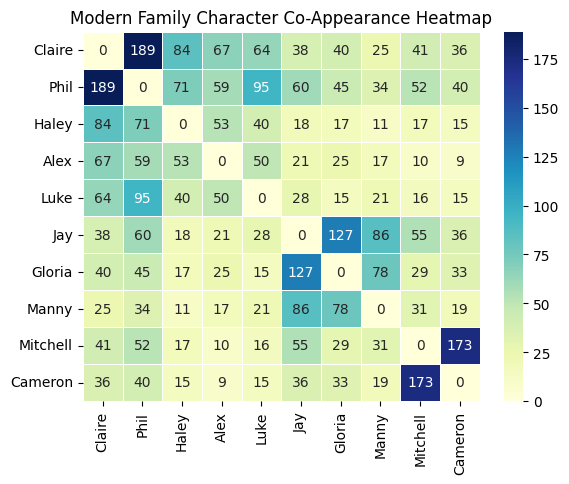

In [ ]:
# Initialize an empty DataFrame (matrix) filled with zeros
matrix = pd.DataFrame(0, index=characters, columns=characters)

# Fill the matrix based on the coappearance dictionary
for (c1, c2), count in coappearance.items():
    matrix.loc[c1, c2] = count
    matrix.loc[c2, c1] = count  # Symmetric for undirected co-appearance

# Set diagonal to 0 (no self-coappearance)
for char in characters:
    matrix.loc[char, char] = 0

# Create a heatmap
sns.heatmap(matrix, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5)
plt.title("Modern Family Character Co-Appearance Heatmap")
plt.show()

### List

In [ ]:
# Convert to a DataFrame for easy viewing
data = []
for (c1, c2), count in coappearance.items():
    if count > 0:
        data.append((c1, c2, count))

df = pd.DataFrame(data, columns=["Character 1", "Character 2", "Scenes Together"])

# Sort by most co-appearances
df = df.sort_values(by="Scenes Together", ascending=False)

# Save to CSV
df.to_csv("coappearance_list.csv", index=False)